# Rover Data Challenge

In this exercise, imagine that Rover has acquired a small pet care start-up. As an analyst, you have been tasked with the responsibility of exploring their database.

### import libraries

In [1]:
import math
import datetime as dt
from collections import Counter
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

### import data

In [2]:
# data on users from the site (dog owners, dog sitters or people who have not transacted on site)
people_person = pd.read_csv("csvs/people_person.csv")

# data table that provides a log for experiments which require user- level segmentations
people_test = pd.read_csv("csvs/people_testsegmentation.csv")

# data on pets registered by owners
pets_pet = pd.read_csv("csvs/pets_pet.csv")

# data for each service that is offered
services_service = pd.read_csv("csvs/services_service.csv")

# data that contains one record for each conversation started on our platform
conversations_conversation = pd.read_csv("csvs/conversations_conversation.csv")

# data that foreign keys since a booking may involve many pets and many pets might have many bookings
conversations_conversation_pets = pd.read_csv("csvs/conversations_conversation_pets.csv")

# data on conversations - Each conversation consists of a series of messages. 
#                         A conversation may contain many messages, but not vice versa.
conversations_message = pd.read_csv("csvs/conversations_message.csv")

# data on reviews which consist of a brief statement and a star rating
conversations_review = pd.read_csv("csvs/conversations_review.csv")

# choice to view data details
if False:
    # print the dimensions of the dataframes
    print("Dimensions of people_person: ", people_person.shape)
    print("Columns of people_persons: ")
    print(people_person.columns.tolist())
    print()
    print("-" * 20)
    print()
    print("Dimensions of people_test: ", people_test.shape)
    print("Columns of people_test: ")
    print(people_test.columns.tolist())
    print()
    print("-" * 20)
    print()
    print("Dimensions of pets_pet: ", pets_pet.shape)
    print("Columns of pets_pet: ")
    print(pets_pet.columns.tolist())
    print()
    print("-" * 20)
    print()
    print("Dimensions of services_service: ", services_service.shape)
    print("Columns of services_service: ")
    print(services_service.columns.tolist())
    print()
    print("-" * 20)
    print()
    print("Dimensions of conversations_conversation: ", conversations_conversation.shape)
    print("Columns of conversations_conversation: ")
    print(conversations_conversation.columns.tolist())
    print()
    print("-" * 20)
    print()
    print("Dimensions of conversations_conversation_pets: ", conversations_conversation_pets.shape)
    print("Columns of conversations_conversation_pets: ")
    print(conversations_conversation_pets.columns.tolist())
    print()
    print("-" * 20)
    print()
    print("Dimensions of conversations_message: ", conversations_message.shape)
    print("Columns of conversations_message: ")
    print(conversations_message.columns.tolist())
    print()
    print("-" * 20)
    print()
    print("Dimensions of conversations_review: ", conversations_review.shape)
    print("Columns of conversations_review: ")
    print(conversations_review.columns.tolist())
    print()

## I. Exploring the Dataset

We begin by asking a few basic questions about the users of this platform. This first exercise is presented with answers so that you can diagnose any issues you might have connecting to or working with the data.

### 1. How many users have signed up?

To answer this, we simply count the number of unique "id" identifiers in the people_person table.

In [3]:
num_unique_users = len(people_person['id'].unique())
print("The number of users signed up is: ", num_unique_users)

The number of users signed up is:  64416


### 2. How many users signed up prior to 2017-01-12?

First, we filter out people who signed up after 2017-01-12 and then count the unique identifiers as in #1.

In [4]:
# filter out people who joined prior to date
num_early_users = len(people_person[people_person['date_joined'] <= '2017-01-12']['id'].unique())

print("The number of users signed up prior to 2017-01-12 is: ", num_early_users)

The number of users signed up prior to 2017-01-12 is:  35500


### 3. What percentage of users have added pets?

To answer this question, we can use the pets_pet dataframe.

In [5]:
# first, find the number of users with pets
num_users_w_pets = len(pets_pet['owner_id'].unique())

# then, use this and num_unique_users to compute the percentage
pct_users_w_pets = round(num_users_w_pets / num_unique_users * 100., 2)

print("The percentage of users who have added pets is: " + str(pct_users_w_pets) + "%." )

The percentage of users who have added pets is: 80.44%.


### 4. Of those owners, how many pets have they added on average?

Take the number of pets (number of rows in pets_pet) and divide by num_users_w_pets.

In [6]:
avg_num_pets = round(len(pets_pet) / num_users_w_pets, 3)

print("The average number of added pets is: ", avg_num_pets)

The average number of added pets is:  1.496


### 5. What percentage of pets that play well with cats?

Sum the "plays_cats" column to get number of pets that play well with cats.  Then, divide by the total number of pets.

In [7]:
pct_play_well_cats = round(pets_pet['plays_cats'].sum() / len(pets_pet) * 100., 2)

print("The percentage of pets that play well with cats is: " + str(pct_play_well_cats) + "%.")

The percentage of pets that play well with cats is: 24.78%.


## II. Conversations and Bookings

Some users can offer pet care services. When an owner needs pet care, they can create a conversation with another user that offers the service they are interested in. After exchanging some messages and possibly meeting in person, that conversation hopefully books. In that case, services are paid for and delivered. Occasionally, some conversations that have booked may be cancelled. Lastly, for uncancelled bookings, both owners and sitters have the option of leaving a review. In the following questions, we explore these concepts.

### 1. What are the possible services and what is the average price per unit for each service type?

To answer this question, we can use the services_service table.

In [8]:
# first, we find the unique service types
service_types = list(services_service['service_type'].unique())

print("The available services are: ")

# now loop thru the service types and print avg price per unit
for service in service_types:
    
    service_df = services_service[services_service['service_type'] == service]
    print("-" * 20)
    print("Average price per unit for " + service + ": $" + str(round(service_df['price'].mean(), 2)))

The available services are: 
--------------------
Average price per unit for boarding: $34.51
--------------------
Average price per unit for dog-walking: $21.98
--------------------
Average price per unit for day-care: $27.01


### 2. How many requests have there been for each service type and what percentage of those have booked? The percentage of those that have booked is called booking rate.

In [9]:
# join conversations_conversation with services_service on ["service_id", "id"] to get service_type 
requests_df = pd.merge(services_service, conversations_conversation, how='inner', left_on="id", right_on="service_id")
requests_df = requests_df[['service_type', 'booked_at']]

# loop thru services and compute number of requests each and how many booked
for service in service_types:
    
    # filter out service
    service_df = requests_df[requests_df['service_type'] == service]
    
    # compute total number of service requests
    num_service_requests = len(service_df)
    
    # those not booked show up as NaN, so drop these
    service_df.dropna(inplace=True)
    
    # compute total number of service requests remaining
    num_service_booked = len(service_df)
    
    # booking rate
    booking_rate = round(num_service_booked / num_service_requests * 100., 2)
    
    print("-" * 20)
    print("There were {} requests for {}".format(num_service_requests, service))
    print("The booking rate for {} was {}%".format(service, booking_rate))

--------------------
There were 26665 requests for boarding
The booking rate for boarding was 40.74%
--------------------
There were 26716 requests for dog-walking
The booking rate for dog-walking was 47.95%
--------------------
There were 26362 requests for day-care
The booking rate for day-care was 35.72%


### 3. What are the cancellation rates for each service?

In [10]:
# join conversations_conversation with services_service on ["service_id", "id"] to get service_type 
requests_df = pd.merge(services_service, conversations_conversation, how='inner', left_on="id", right_on="service_id")
requests_df = requests_df[['service_type', 'cancelled_at']]

# loop thru services and compute number of requests each and how many cancelled
for service in service_types:
    
    # filter out service
    service_df = requests_df[requests_df['service_type'] == service]
    
    # compute total number of service requests
    num_service_requests = len(service_df)
    
    # those not canceled show up as NaN, so drop these
    service_df.dropna(inplace=True)
    
    # compute total number of service requests remaining
    num_service_cancelled = len(service_df)
    
    # cancelled rate
    cancellation_rate = round(num_service_cancelled / num_service_requests * 100., 2)
    
    print("-" * 20)
    print("There were {} requests for {}".format(num_service_requests, service))
    print("The cancellation rate for {} was {}%".format(service, cancellation_rate))

--------------------
There were 26665 requests for boarding
The cancellation rate for boarding was 3.94%
--------------------
There were 26716 requests for dog-walking
The cancellation rate for dog-walking was 4.56%
--------------------
There were 26362 requests for day-care
The cancellation rate for day-care was 3.49%


### 4. For uncancelled bookings, is the owner or provider more likely to leave a review and which tends to leave better reviews? How would you narrate this finding to a business partner?

To answer these questions, we need to make use of the conversation_review and conversation_conversations tables.

In [11]:
# extract only the columns that we need from the review table
review_test = conversations_review[['id', 'stars', 'conversation_id', 'reviewer_id']]

# extract only the columns we need from the conversation table
conversation_test = conversations_conversation[['id', 'requester_id', 'booked_at', 'cancelled_at']]

# filter out requests that were never booked
conversation_test = conversation_test[pd.notnull(conversation_test['booked_at'])]

# filter out bookings that were NOT cancelled
conversation_test = conversation_test[pd.isnull(conversation_test['cancelled_at'])]

# further filter the columns we need
conversation_test = conversation_test[['id', 'requester_id']]

# merge the two tables into one table that will allow us to easily answer the questions
review_test = pd.merge(review_test, conversation_test, how='inner', left_on="conversation_id", right_on="id")

# and keep only the columns we need
review_test = review_test[['stars', 'reviewer_id', 'requester_id']]

# build a column that tells us if the review came from the pet owner
review_test['review_by_requester'] = review_test['reviewer_id'] == review_test['requester_id']

# count the number of owner reviews and compute average review score
owner_reviews = review_test[review_test['review_by_requester'] == True]
num_owner_reviews = len(owner_reviews)
avg_owner_review = round(owner_reviews['stars'].mean(), 2)

# count the number of provider reviews and compute average review score
provider_reviews = review_test[review_test['review_by_requester'] == False]
num_provider_reviews = len(provider_reviews)
avg_provider_review = round(provider_reviews['stars'].mean(), 2)

print('-' * 20)
print("Number of owner reviews: ", num_owner_reviews)
print("Owner average review score: ", avg_owner_review)

print('-' * 20)
print("Number of provider reviews: ", num_provider_reviews)
print("Provider average review score: ", avg_provider_review)

--------------------
Number of owner reviews:  22493
Owner average review score:  4.41
--------------------
Number of provider reviews:  6043
Provider average review score:  3.89


It appears that owners are much more likely to leave a review.  Also, on average, owner reviews tend to be higher by 0.5 stars.

I would think that people that are very happy with a service will want to reward providers, thus, the higher scores.  Also, from my past experience with other similar services, I would think that providers will encourage owners (who they think are happy with their service) to leave reviews since that is essentially how they advertise.

## III. Recent Daily Booking Rate

The snapshot of this database was taken on 2017-07-11 at midnight and only contains data reflecting events prior to that date. A junior analyst is investigating daily booking rate during the days prior to the snapshot and is concerned about an apparent downward trend. You are tasked with helping them out.

### 1. First, let's reproduce their results. They tell you that daily booking rate is defined to be the percentage of conversations created each day that eventually book. What is the daily booking rate for each of the 90 days prior to the snapshot? Is there a downward trend?

To find the daily booking rate, we make use of the conversations_conversation table.  

First, we define the end date (2017-07-11) and the beginning date (which is 90 days prior to the end date) and filter the dataframe such that it only includes entries from those dates.

We then group by the date and count all of the conversations that started that day and sum up the bookings that resulted.  Dividing the latter by the former gives us the booking rate for each day.

To answer whether or not a downward trend occurs, we plot the booking rate over the past 90 days.  Because the data could be volatile (changing wildly from day-to-day), we also compute the "rolling mean" which averages over the past 30 days and produces a much more stable plot.

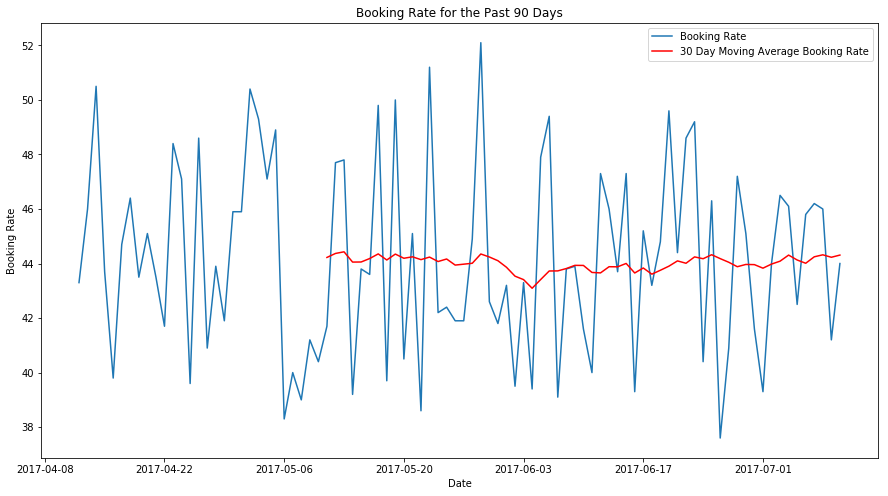

In [12]:
# keep only the columns we need from the converation table
conversations_df = conversations_conversation[['start_date', 'booked_at']]

# define the end and start dates 
snapshot_date = dt.datetime.strptime('2017-07-11', '%Y-%m-%d')
begin_date = snapshot_date - dt.timedelta(days=90)

# keep only dates in the range we're interested in
conversations_df['start_date'] = pd.to_datetime(conversations_df['start_date'])
conversations_df = conversations_df[(conversations_df['start_date'] >= begin_date) &\
                                    (conversations_df['start_date'] < snapshot_date)]

# make a boolean column for booked
conversations_df['booked'] = pd.notnull(conversations_df['booked_at'])

# drop the (now) unnecessary "booked_at" column
conversations_df.drop('booked_at', axis=1, inplace=True)

# group by day and sum booked
grouped_sum_df = pd.DataFrame(conversations_df.groupby('start_date')['booked'].sum())
grouped_sum_df.reset_index(inplace=True, drop=False)
grouped_sum_df.sort_values(by='start_date', inplace=True)

# group by day and count booked
grouped_count_df = pd.DataFrame(conversations_df.groupby('start_date')['booked'].count())
grouped_count_df.reset_index(inplace=True, drop=False)
grouped_count_df.sort_values(by='start_date', inplace=True)
grouped_count_df.rename(columns={'booked': 'started'}, inplace=True)

grouped_df = pd.merge(grouped_sum_df, grouped_count_df, on='start_date')

# compute the booking rate for each day
grouped_df['booking_rate']  = round(grouped_df['booked'] / grouped_df['started'] * 100., 1)

# compute a "rolling mean" to smooth out the curve
grouped_df['rolling_mean'] = grouped_df['booking_rate'].rolling(window=30).mean()

# plot the booking rate
fig = plt.figure(figsize=(15, 8))
plt.plot_date(grouped_df['start_date'].tolist(), grouped_df['booking_rate'].tolist(), '-', label='Booking Rate')
plt.plot_date(grouped_df['start_date'].tolist(), grouped_df['rolling_mean'].tolist(), '-', color='red', label='30 Day Moving Average Booking Rate')
plt.xlabel("Date")
plt.ylabel("Booking Rate")
plt.title("Booking Rate for the Past 90 Days")
plt.legend(loc='best')
plt.show()

The booking rate does indeed appear to be very volatile over time, but looking at the 30-day moving average it becomes very apparent that there is NOT a long-term downward trend.

### 2. Can you narrate a reason why this trend exists? Is there a reason to be concerned?

As stated above, the downward trend over the past couple of days (if it does exist) is nothing to be worried about.  We have observed that the booking rate is extremely volatile; however, when viewed as a moving average, the booking rate appears to be quite steady. 

## IV. Analyzing Take Rate

In order to do the next exercise, you will need to understand the fee structure for this company. Each user has a fee associated with their account (recorded on people_person). If that user books as an owner, the company charges a service fee (in addition to the booking total) that is a percentage of the booking total (to a maximum of 50 dollars). Also, each service has a fee amount (recorded on services_service ). Before a provider receives their payment, the company takes a percentage of the booking total as dictated by that fee. As an example, suppose an owner has a fee amount of 5% and books with a service that has a fee amount of 15%. If the booking was for 100 dollars, then the owner would get charged 105 dollars (adding the owner’s fee). The 5 dollar owner fee would go to the company. An additional 15 dollars would also go to the company since the service had a 15% fee associated to it. The remaining 85 dollars would go to the provider.

### 1. In each month, what were the gross billings and net revenue?

In [13]:
conversation_df = conversations_conversation[['added', 'requester_id', 'service_id', 'booking_total']]
conversation_df['added'] = pd.to_datetime(conversation_df['added'])

user_df = people_person[['id', 'fee']]
user_df.rename(columns={'id': 'requester_id', 'fee': 'user_fee'}, inplace=True)

service_df = services_service[['id', 'fee']]
service_df.rename(columns={'id': 'service_id', 'fee': 'service_fee'}, inplace=True)

take_rate_df = pd.merge(conversation_df, user_df, on='requester_id')
take_rate_df = pd.merge(take_rate_df, service_df, on='service_id')

# define gross billings column
take_rate_df['gross_billings'] = take_rate_df['booking_total'] * ( 1 + take_rate_df['user_fee'])

# define net revenue column
take_rate_df['net_revenue'] = take_rate_df['booking_total'] * (take_rate_df['user_fee'] + take_rate_df['service_fee'])

# keep only columns we need
take_rate_df = take_rate_df[['added', 'gross_billings', 'net_revenue']]
take_rate_df.set_index('added', inplace=True)

# groupby by year and month and sum gross_billings and net_revenue
take_rate_grouped = pd.groupby(take_rate_df,
                               by=[take_rate_df.index.year,take_rate_df.index.month])[['gross_billings', 'net_revenue']].sum()

take_rate_grouped.index.names = ['year', 'month']

take_rate_grouped

gross_billings  net_revenue
year month                             
2015 7             5306.04       884.34
     8            32549.22      5424.87
     9            52480.02      8746.67
     10          105207.90     17534.65
     11          128539.38     21423.23
     12          177298.62     32184.92
2016 1           232145.34     43343.34
     2           256996.50     48174.45
     3           350685.03     65975.83
     4           389562.60     73375.60
     5           446291.49     86739.59
     6           518787.24    104522.39
     7           573768.48    118272.33
     8           649187.40    136863.00
     9           696129.84    149740.89
     10          781151.49    169266.49
     11          834700.56    186652.41
     12          958485.53    220659.58
2017 1          1010287.50    234667.00
     2          1005105.64    236198.69
     3          1203661.83    284086.43
     4          1260994.68    299221.78
     5          1459688.00    350271.40
     6          1560214.45    376001.65
     7           562715.89    135618.09

### 2. Define take rate to be the percentage of gross billings that is net revenue. In the previous example, the take rate is slightly more than 19% since \$20/$105 is approximately 0.1905. In each month, what was the aggregate take rate?

Using the results from above, we can easily compute the take rate for each month.

In [14]:
# compute the monthly take rate
take_rate_grouped['take_rate'] = round((take_rate_grouped['net_revenue'] / take_rate_grouped['gross_billings']) * 100, 1)

# keep only the column we want
take_rate_grouped = pd.DataFrame(take_rate_grouped['take_rate'])

take_rate_grouped

take_rate
year month           
2015 7           16.7
     8           16.7
     9           16.7
     10          16.7
     11          16.7
     12          18.2
2016 1           18.7
     2           18.7
     3           18.8
     4           18.8
     5           19.4
     6           20.1
     7           20.6
     8           21.1
     9           21.5
     10          21.7
     11          22.4
     12          23.0
2017 1           23.2
     2           23.5
     3           23.6
     4           23.7
     5           24.0
     6           24.1
     7           24.1

### 3. Did take rate trend up or trend down or remain unchanged over time?

Take rate definitely trended up over time.  We can see this even more clearly by plotting the trend rate as a funciton of the date.

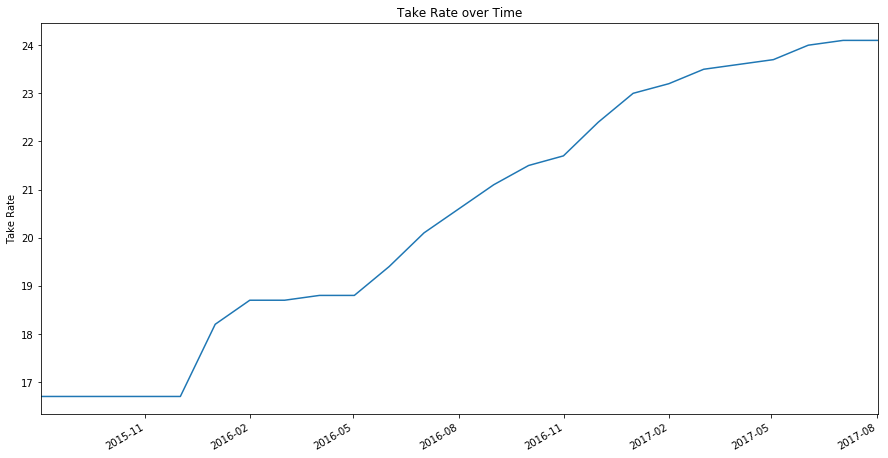

In [15]:
plotting_df = pd.DataFrame(take_rate_grouped[['take_rate']])
i = pd.Index(pd.datetime(year, 1, 1) + pd.Timedelta(month, unit='M') for year, month in plotting_df.index)
plotting_df.index = i

fig = plt.figure(figsize=(15, 8))
plotting_df['take_rate'].plot()
plt.title("Take Rate over Time")
plt.ylabel("Take Rate")
plt.show()

### 4. If it did change, investigate why and provide an explanation. Be sure to provide additional data/charts/evidence that justify your explanation. Any claims should be backed by data.

To answer this question, it helps to take a look at the formula for take rate and break it down.

$$ TakeRate = \frac{NetRevenue}{GrossBilling} = \frac{BookTotal \,\, ( UserFee + ServiceFee )}{BookTotal \,\, ( 1 + UserFee)} $$

Or:

$$ TakeRate = \frac{UserFee + ServiceFee}{1 + UserFee} $$

From this expression, it becomes clear that a rise in take rate must be coming mostly from a rise in service fees (since a rise in user fees is balanced in the numerator and denominator).

To test this, we can plot the relative change in user and service fees defined generally as:

$$ \Delta Fee = \frac{Fee - InitialFee}{InitialFee} $$

where "InitialFee" was the average service/user fee at the beginning of the time period of interest.

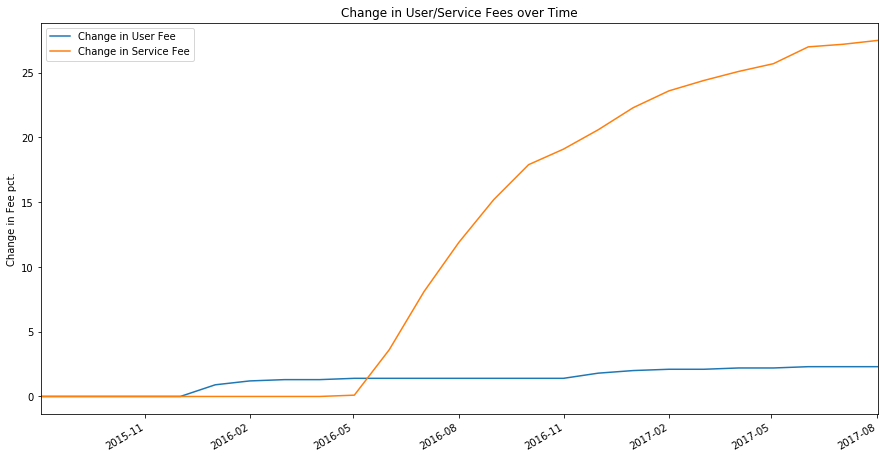

In [16]:
conversation_df = conversations_conversation[['added', 'requester_id', 'service_id', 'booking_total']]
conversation_df['added'] = pd.to_datetime(conversation_df['added'])

user_df = people_person[['id', 'fee']]
user_df.rename(columns={'id': 'requester_id', 'fee': 'user_fee'}, inplace=True)

service_df = services_service[['id', 'fee']]
service_df.rename(columns={'id': 'service_id', 'fee': 'service_fee'}, inplace=True)

take_rate_df = pd.merge(conversation_df, user_df, on='requester_id')
take_rate_df = pd.merge(take_rate_df, service_df, on='service_id')

# choose the columns we need from the data table that we created above
take_rate_change_df = take_rate_df[['added', 'user_fee', 'service_fee']]
take_rate_change_df.set_index('added', inplace=True)

# groupby by year and month and sum gross_billings and net_revenue
take_rate_changed_grouped = pd.groupby(take_rate_change_df,
                               by=[take_rate_change_df.index.year,take_rate_change_df.index.month])[['user_fee', 'service_fee']].mean()
take_rate_changed_grouped.index.names = ['year', 'month']

# compute the change in service fees
take_rate_changed_grouped['delta_service_fee'] = \
    round((take_rate_changed_grouped['service_fee'] - take_rate_changed_grouped['service_fee'].min()) / take_rate_changed_grouped['service_fee'].min() * 100., 1)

# compute the change in user fees
take_rate_changed_grouped['delta_user_fee'] = \
    round((take_rate_changed_grouped['user_fee'] - take_rate_changed_grouped['user_fee'].min()) / take_rate_changed_grouped['user_fee'].min(), 1)

# take the columns that we want to plot
take_rate_changed_grouped = take_rate_changed_grouped[['delta_service_fee', 'delta_user_fee']]    

# plot the change in user and service fees
plotting_df = pd.DataFrame(take_rate_changed_grouped[['delta_user_fee', 'delta_service_fee']])
i = pd.Index(pd.datetime(year, 1, 1) + pd.Timedelta(month, unit='M') for year, month in plotting_df.index)
plotting_df.index = i

fig = plt.figure(figsize=(15, 8))
plotting_df['delta_user_fee'].plot(label='Change in User Fee')
plotting_df['delta_service_fee'].plot(label='Change in Service Fee')
plt.title("Change in User/Service Fees over Time")
plt.ylabel("Change in Fee pct.")
plt.legend(loc='best')
plt.show()

Comparing this plot with the plot for take rate, it is easy to see that the sharp rise in service fees is indeed driving the upward trend in the take rate.

## V. New Conversation Flow

Internal documents indicate that this recently acquired company was performing many A/B tests; we would like to investigate one. This platform had a conversation page where owners and service providers could exchange messages as they organized their booking. The team thought this page could use a re-design and set out to improve its UI. A product manager then set up a test to measure the new page's effectiveness. On 2017-03-13 , an A/B test was launched. For those owners who sent a request, they would be randomly assigned to variant or holdout groups. Those users who are in the variant group would see the new conversation flow. However, those in the holdout group would see the old conversation flow. Providers would always see the old conversation flow.

### 1. Did conversations with the new conversation page book at a higher rate?

In [17]:
# from people_test extract the A/B test
conversation_flow_df = people_test[people_test['test_name'] == 'New Conversation Flow']
conversation_flow_df.drop("test_name", axis=1, inplace=True)
conversation_flow_df.rename(columns={"person_id": "requester_id"}, inplace=True)

# number cases in each group
group_counter = Counter(conversation_flow_df['test_group'])
num_holdout = group_counter['holdout']
num_variant = group_counter['variant']

# join with conversations_conversation to get booked_at column
conversation_flow_df = pd.merge(conversation_flow_df, conversations_conversation, on=['added', 'requester_id'])

# keep only the columns we need
conversation_flow_df = conversation_flow_df[['test_group', 'added', 'booked_at']]

# define a boolean "booked" column
conversation_flow_df['booked'] = pd.notnull(conversation_flow_df['booked_at'])

# get number of holdout bookings
num_holdout_books = len(conversation_flow_df[(conversation_flow_df['test_group'] == 'holdout') &\
                                             (conversation_flow_df['booked'] == True)])

# get number of variant bookings
num_variant_books = len(conversation_flow_df[(conversation_flow_df['test_group'] == 'variant') &\
                                             (conversation_flow_df['booked'] == True)])

print("Rate of bookings on holdout group: ", round(num_holdout_books / num_holdout, 2))
print("Rate of bookings on variant group: ", round(num_variant_books / num_variant, 2))

Rate of bookings on holdout group:  0.4
Rate of bookings on variant group:  0.47


### 2. Is it statistically significant?

To test the statistical significance of these results, we can perform a chi-squared test and compute the p-value. Without getting into the details of statistics, the p-value is very useful in determining if a result is significant.  The general rule is... the smaller the p-value, the more significant the result.  As a general rule of thumb, a p-value less than 0.001 signals an extremely siginificant result.

To compute chi-squared and the p-value, we make use of the Python scipy stats package:

In [18]:
# to test the statistical significance, we can use a chi-squared test
contingency_matrix = pd.DataFrame([[num_holdout-num_holdout_books, num_holdout_books],
                                  [num_variant-num_variant_books, num_variant_books]])

contingency_matrix.index = ['holdout', 'variant']
#contingency_matrix.reset_index(inplace=True, drop=False)

contingency_matrix.columns = ["not booked", "booked"]

observed = contingency_matrix.values

result = chi2_contingency(observed)
chisq, p = result[:2]
print('chisq = {}, p-value = {}'.format(chisq, p))

chisq = 110.02654262981699, p-value = 9.668740242878258e-26


With such an extremely small value of p, we can say beyond a doubt (with better than 99% confidence!) that our results are significant: the "variant" version of the webpage does indeed lead to more bookings.

## VI. Search Engine Marketing

Search engine advertising is a huge driver of new user accounts. Users that are aquired through search engine marketing can be identified by looking at people_person.channel . These users will have 'Google' listed there.
Historically, this company spent an average of \$30 per account to advertise in the 2nd position on Google. However, on 2017-04-12 , they decided to start bidding for the 1st position. Since 2017-04-12 , they have spent \$210285 in total.

### 1. For each day, determine the count of users that joined and were acquired through Google. Plot this and confirm there is an inflection point on or near 2017-04-12 .

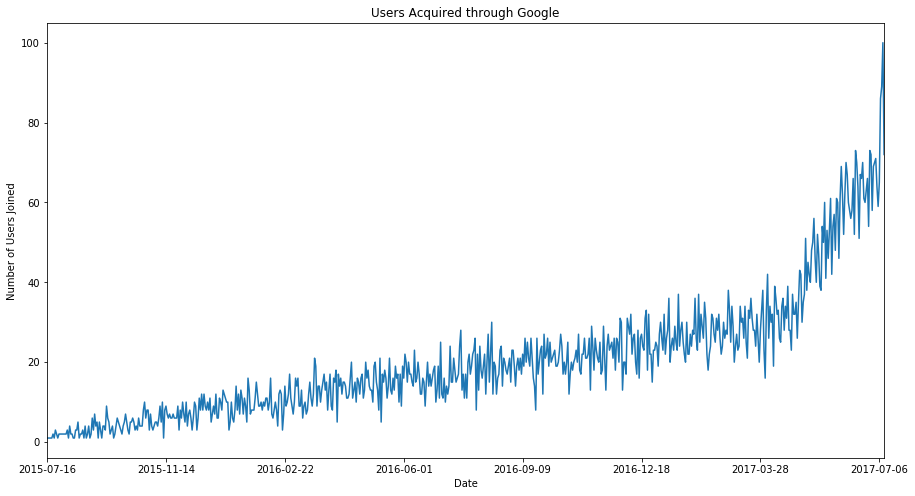

In [19]:
people_person['date_joined'] = pd.to_datetime(people_person['date_joined'])

google_joined = pd.DataFrame(people_person[people_person['channel'] == 'Google']['date_joined'])

google_joined['date_joined'] = google_joined.date_joined.map(lambda x: x.strftime('%Y-%m-%d'))

google_joined_count = dict(Counter(google_joined['date_joined']))

count_df = pd.DataFrame(google_joined_count, index=[0]).T
count_df.columns = ['num_joined']

fig = plt.figure(figsize=(15, 8))
count_df['num_joined'].plot()
plt.title("Users Acquired through Google")
plt.xlabel("Date")
plt.ylabel("Number of Users Joined")
plt.show()

The inflection point near 2017-04-12 is clearly evident.

### 2. How many users were acquired via Google advertising since 2017-04-12 and what was the average cost per account?

In [20]:
new_google_joined = google_joined[google_joined['date_joined'] >= '2017-04-12']

num_new_google_joined = len(new_google_joined)

print("Number of users acquired via Google since 2017-04-12: ", len(new_google_joined))

total_cost = 210285

print("Average cost per account: $" + str(int(total_cost / num_new_google_joined)))

Number of users acquired via Google since 2017-04-12:  4673
Average cost per account: $45


### 3. Estimate how many users would have been acquired had the company not changed its bidding strategy. What would have been the marketing spend in that case?

In [21]:
# to find the estimated number of users acquired, we can fit a trend line to the data prior to 2017-04-12
past_google_joined = google_joined[google_joined['date_joined'] < '2017-04-12']

past_google_joined_count = dict(Counter(past_google_joined['date_joined']))

count_df = pd.DataFrame(past_google_joined_count, index=[0]).T
count_df.columns = ['num_joined']

count_df = count_df.reset_index()

count_df['index'] = pd.to_datetime(count_df['index'])

count_df['days'] = (count_df['index'] - count_df['index'].min()).dt.days

count_df.drop('index', axis=1, inplace=True)

x = count_df['days'].tolist()
y = count_df['num_joined'].tolist()
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

m = round(slope, 3)
b = round(intercept, 3)

print("slope of linear fit: ", m)
print("intercept of linear fit: ", b)

slope of linear fit:  0.046
intercept of linear fit:  0.735


So, the linear regression results in the linear equation:

$$ NumberUsers = (0.046) \,\, day + 0.735 $$

To get the estimated number of users after 2017-04-12, we need to sum this equation (or, in terms of calculus, integrate this equation).  The resulting equation would be:

$$ TotalNumberUsers = (0.046) \,\, \frac{(\Delta \, days)^2}{2} + 0.735 \,\, (\Delta \, days) $$

where the "delta days" is just the number of days from 2017-04-12 to 2017-07-06 (i.e., 85 days).

In [22]:
days = (pd.to_datetime('2017-07-06') - pd.to_datetime('2017-04-12')) / pd.Timedelta(1, 'd')
total_num_users = m * math.pow(days, 2) / 2 + b * days
cost_per_acct = 30
marketing_spend = int(round(cost_per_acct * total_num_users, 0))
print("Estimated number of users without change in strategy: ", int(round(total_num_users, 0)))
print("Marketing spend without change in strategy: $" + str(marketing_spend))

Estimated number of users without change in strategy:  229
Marketing spend without change in strategy: $6860


### 4. How many additional accounts where created? What was the marginal cost per account for these additional accounts?

In [23]:
num_add_accts = int(num_new_google_joined - total_num_users)
print("Number of additinoal accounts created: ", num_add_accts)

cost_diff = total_cost - marketing_spend
marginal_cost_per_acct = cost_diff / num_add_accts
print("Marginal cost per account: $" + str(round(marginal_cost_per_acct, 2)))

Number of additinoal accounts created:  4444
Marginal cost per account: $45.78
